# Neural Net Homework 6 - CS 189

1. The goal is to implement a 2 layer fully connected Neural Net
2. The data set consists of 124,800 iamges and the test split of 20,800 images. 

### Letters Dataset

In [5]:
## data prep
DIRECTORY = "/Users/Jaume/Desktop/SPRING 2017/CS189/HW6/hw6_data_dist/letters_data.mat"
data = sio.loadmat(DIRECTORY)

In [6]:
data_test = data['test_x']
data_train = data['train_x']
labels = data['train_y']

In [7]:
# shuffle the data
training_data = np.concatenate([data_train, labels], axis=1)
np.random.shuffle(training_data)

In [8]:
# split train and validation sets, 20% is 24960
scaler = pre.StandardScaler()

train_data = training_data[24960:, :]

y_train = np.array(train_data[:,-1])
X_train = scaler.fit_transform(train_data[:, 0:-1])

validation_data = training_data[0:24960, :]

y_validation = validation_data[:,-1]
X_validation = scaler.transform(validation_data[:, 0:-1])

y_train = y_train.ravel()

X_test = scaler.fit_transform(data_test)

/Users/Jaume/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [9]:
# onehot encode the labels
values = y_train
n_values = np.max(values) 
y_t=np.eye(n_values)[values-1]

In [10]:
# prevent saturation
#y_t[y_t == 0.] = 0.15
#y_t[y_t == 1.] = 0.85

In [12]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape

((99840, 784), (99840,), (24960, 784), (24960,), (20800, 784))

### Problem 1: Derivations


In [13]:
import numpy as np 
import pandas as pd 
import scipy.io as sio
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
from time import time

In [14]:
# supporting functions

# Returns the matrix X with a bias column added (1s)
def add_bias(X):
    #print(X.shape, np.array([X]).T.shape, np.ones(X.shape[0]).shape)
    new_X = np.append(X,np.ones(X.shape[0]).reshape(X.shape[0],1), axis=1)
    return new_X

def decr_eps(eps,n):
    return float(eps)/float(n)

def test(predicted, true):
    return float(np.sum(np.isclose(predicted, true))) / float(predicted.shape[0])

In [25]:
# Building the Neural Net Class

class NN(object):
    def __init__(self):        
        self.inputSize = 784
        self.outputSize = 26
        self.hiddenSize = 800
        
###############
    
    def logistic(self, s):
        return 1.0/(1.0+np.exp(-s))
    
    def forward_pass(self, x):
        self.a = np.dot(self.V, x)
        #print('a: ', self.a.shape)
        self.b = np.tanh(self.a).T #*0.5
        #print('b: ', self.b.shape)
        self.b_2 = add_bias(self.b).T #np.append(self.b, 1)
        #print('b_2: ', self.b_2.shape)
        self.c = np.dot(self.W, self.b_2)
        #print(self.c.shape)
        #print('c: ',self.c)
        #print('logistic c: ', self.logistic(self.c))
        return self.logistic(self.c)
    
    def logisticLoss(self,z,y):
        loss = 0
        #print("predicted - true: ", z, y)
        #print(z.shape, y.shape)
        for i in range(z.shape[0]):
            y_i = y[i]
            z_i = z[i]
            l = y_i*np.log(z_i) + (1.0 - y_i)*np.log(1.0 - z_i)
            loss += l
        return -loss
    
    def BGD(self, X, y, k, eps, lmb):
        idx = np.random.randint(X.shape[0], size = k)
        X_i = X[idx, :].T
        y_i = y[idx].T
        
        self.predicted = self.forward_pass(X_i)
        
        diff = self.predicted - y_i
        #print('diff: ', diff.shape)
        #print('b_2: ', self.b)
        LW = diff @ self.b_2.T + 2*lmb*np.linalg.norm(self.W)
        d = np.dot(self.W.T, diff)[:-1]
        #print('d: ', d.shape)
        e = 1.0 - np.tanh(self.a)**2
        #print('e: ', e.shape)
        n = np.multiply(d,e)
        #print(X_i.shape)
        LV = np.dot(X_i,n.T).T + 2*lmb*np.linalg.norm(self.V)
        #LV = np.dot(X_i.reshape(X_i.shape[0], 1), n.reshape(n.shape[0], 1).T).T + 2*lmb*np.linalg.norm(self.V)

        self.V = self.V - eps*LV
        self.W = self.W - eps*LW
        
        return self.logisticLoss(self.predicted, y_i)        

    def SGD(self, X, y, eps, lmb):
        # random sample from training set
        idx = np.random.randint(0, X.shape[0])
        X_i = X[idx, :]
        y_i = y[idx]
        
        self.predicted = self.forward_pass(X_i)
        
        diff = self.predicted - y_i
        LW = diff.reshape(diff.shape[0],1) @ self.b_2.reshape(self.b_2.shape[0], 1).T + 2*lmb*np.linalg.norm(self.W)
        d = np.dot(self.W.T, diff)[:-1]
        e = 1.0 - np.tanh(self.a)**2
        n = np.multiply(d,e)
        LV = np.dot(X_i.reshape(X_i.shape[0], 1), n.reshape(n.shape[0], 1).T).T + 2*lmb*np.linalg.norm(self.V)

        self.V = self.V - eps*LV
        self.W = self.W - eps*LW
        
        return self.logisticLoss(self.predicted, y_i)

    def back_prop(self, X, y, params):

        iterations = 1
        k = params[3]
        eps = params[0]
        iters = params[1]/k
        lmb = params[2]
        X = add_bias(X)
        
        loss = []
        l5 = []
        acc = 0
        while True:
            # stopping criteria:
            if iterations == iters:
                break
            l = self.BGD(X, y, k, eps, lmb)
            # loss
            l5.append(l)
            # print iteration count:
            if iterations%(10000/k) ==0:
                loss.append(np.mean(l5))
                print('iteration number: ', iterations*k, 'of ', iters*k)
                l5 = []
                pred = self.predict(add_bias(X_validation))
                t = test(pred, y_validation)
                print('Accuracy: ', t)
                if (t <= acc):
                    break
                acc = t
            iterations += 1
        
        return loss
    
    def train(self, X, y, params):
        
        t0 = time()
        #Initialize Weights
        self.V = 0.1*np.random.randn(self.hiddenSize, self.inputSize + 1)
        self.W = 0.1*np.random.randn(self.outputSize, self.hiddenSize + 1)
        loss = self.back_prop(X,y, params)
        return loss

    def predict(self, X):
        a = np.dot(X, self.V.T)
        #print('a = ', a.shape)
        b = np.tanh(a)
        #print('b = ', b.shape)
        b_2 = add_bias(b)
        #print('b_2 = ', b_2)
        c = np.dot(self.W, b_2.T)
        #print(self.c.shape)
        preds = self.logistic(c).T
        #print(preds[0].shape)
        pred_nums = np.array([np.argmax(smpl)+1 for smpl in preds])
        return pred_nums
        

In [26]:
# hypertuning learning rate
net2 = NN()
#eps = np.logspace(-6,1, 20)
#for ep in eps:
#    net.train(X_train, y_t, [ep, 500])
#    net.predict(add_bias(X_validation))
loss2 = net2.train(X_train, y_t, [0.001, 500000, 0.0, 50])

iteration number:  10000 of  500000.0
Accuracy:  0.602323717948718
iteration number:  20000 of  500000.0
Accuracy:  0.6673477564102565
iteration number:  30000 of  500000.0
Accuracy:  0.6915064102564102
iteration number:  40000 of  500000.0
Accuracy:  0.7145833333333333
iteration number:  50000 of  500000.0
Accuracy:  0.7312099358974359
iteration number:  60000 of  500000.0
Accuracy:  0.7434294871794872
iteration number:  70000 of  500000.0
Accuracy:  0.75
iteration number:  80000 of  500000.0
Accuracy:  0.7565705128205128
iteration number:  90000 of  500000.0
Accuracy:  0.7618589743589743
iteration number:  100000 of  500000.0
Accuracy:  0.7743990384615385
iteration number:  110000 of  500000.0
Accuracy:  0.7816506410256411
iteration number:  120000 of  500000.0
Accuracy:  0.7824919871794872
iteration number:  130000 of  500000.0
Accuracy:  0.7889022435897436
iteration number:  140000 of  500000.0
Accuracy:  0.7957932692307692
iteration number:  150000 of  500000.0
Accuracy:  0.797035

In [27]:
val_pred2 = net2.predict(add_bias(X_validation))
train_pred2 = net2.predict(add_bias(X_train))
print(y_validation)
print(val_pred2)
print(test(val_pred2, y_validation), test(train_pred2, y_train))

[25 25 10 ..., 26  6 13]
[25 25 10 ..., 23  6 13]
0.8046474358974359 0.8525741185897436


# Average Loss Every 1000 iterations

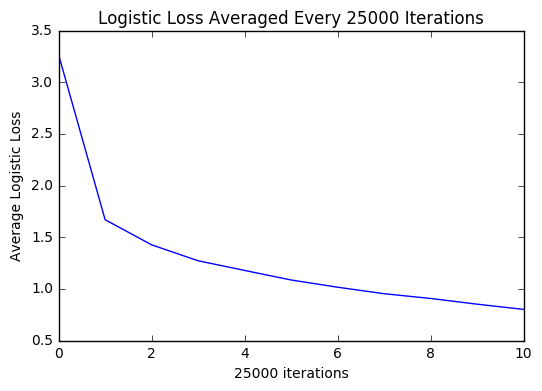

In [24]:
plt.plot(loss2)
plt.xlabel('25000 iterations')
plt.ylabel('Average Logistic Loss')
plt.title('Logistic Loss Averaged Every 25000 Iterations')
plt.show()

### Prediction Results

In [203]:
pred = net.predict(add_bias(X_train))

In [204]:
# training accs
print(y_train)
print(pred)
print(test(pred, y_train))

[17  5 13 ..., 25 10 10]
[17  5 13 ..., 25 10 10]
0.9388521634615384


In [205]:
# validation accs
val_pred = net.predict(add_bias(X_validation))
print(y_validation)
print(val_pred)
print(test(val_pred, y_validation))


[22  7  5 ...,  8 19 11]
[21  9  5 ...,  8 19 12]
0.8555288461538462


### Kaggle Submission: 0.85837

In [213]:
prediction = pd.DataFrame(net.predict(add_bias(X_test)), dtype=int)
prediction.index += 1
prediction.index.rename('Id', inplace=True)
prediction.to_csv('outcome_letters.csv', header =['Category'])

### Image Visualization

In [355]:
def plot_image(image, label, pred):
    image = image.reshape(28,28)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    title = 'Label: ' + label + ', ' + 'Classified as: ' + pred
    plt.title(title)
    plt.show()
    
import string
alphabet = {}
num = 1
alph = 'abcdefghijklmnopqrstuvwxyz'
for letter in alph:
    alphabet[num] = letter
    num += 1
correct = []
incorrect = []
for i in range(len(val_pred2)):
    if np.isclose(val_pred2[i], y_validation[i]):
        if len(correct) <5:
            correct.append(i)
    if not np.isclose(val_pred2[i], y_validation[i]):
        if len(incorrect) <5:
            incorrect.append(i)
    if len(correct)== 5 and len(incorrect)==5:
        break

In [356]:
print(correct, incorrect, val_pred2)

[1, 2, 3, 4, 5] [0, 15, 25, 26, 28] [21  7  5 ...,  8 19 11]


CORRECT


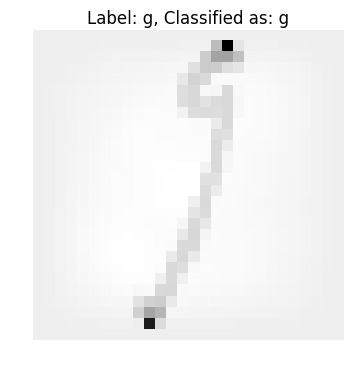

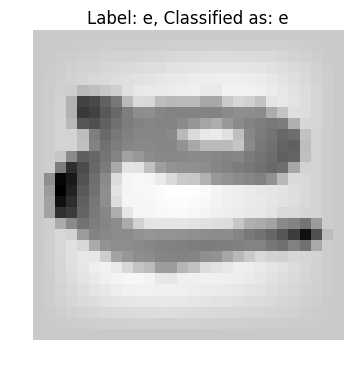

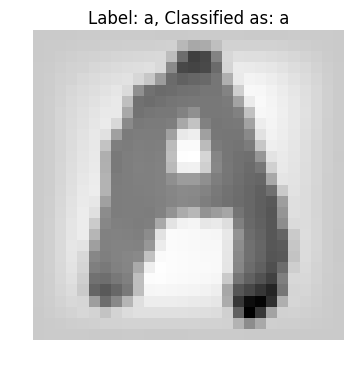

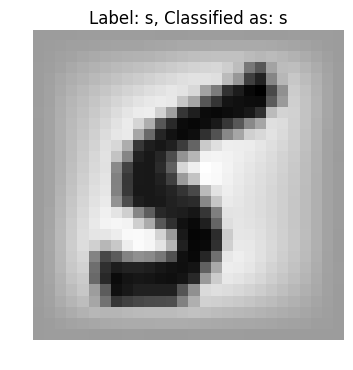

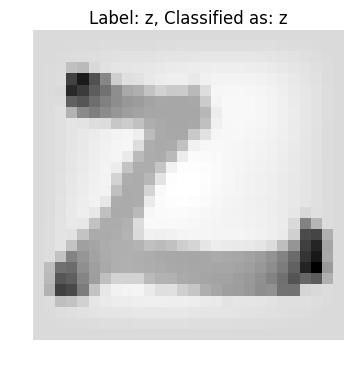

INCORRECT


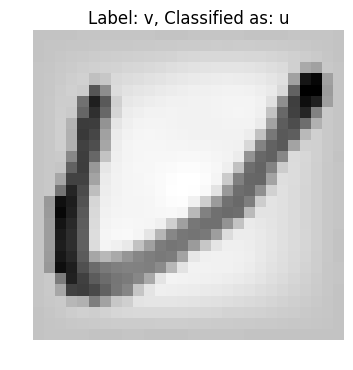

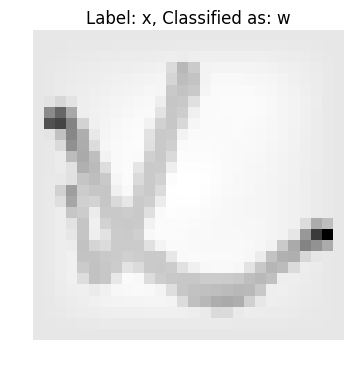

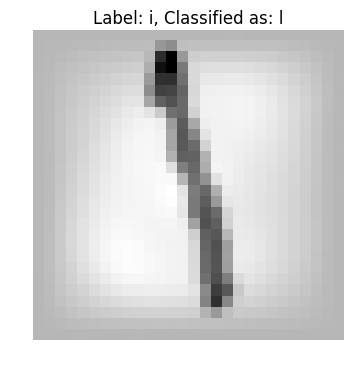

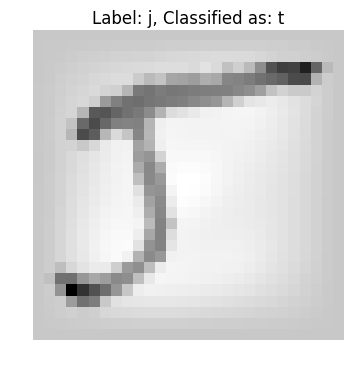

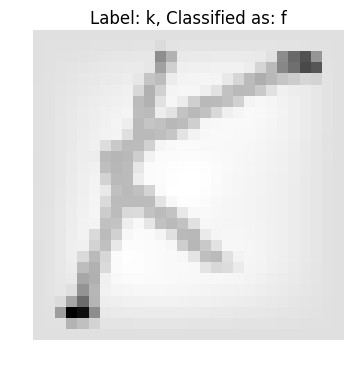

In [357]:
print('CORRECT')
for i in correct:
    plot_image(X_validation[i,:], alphabet[y_validation[i]], alphabet[val_pred2[i]])
print('INCORRECT')
for j in incorrect:
    plot_image(X_validation[j,:], alphabet[y_validation[j]], alphabet[val_pred2[j]])